<a href="https://colab.research.google.com/github/ashishmission93/Ashish-Autonomous-Vehicles-and-Drones-Projects/blob/main/project_3_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

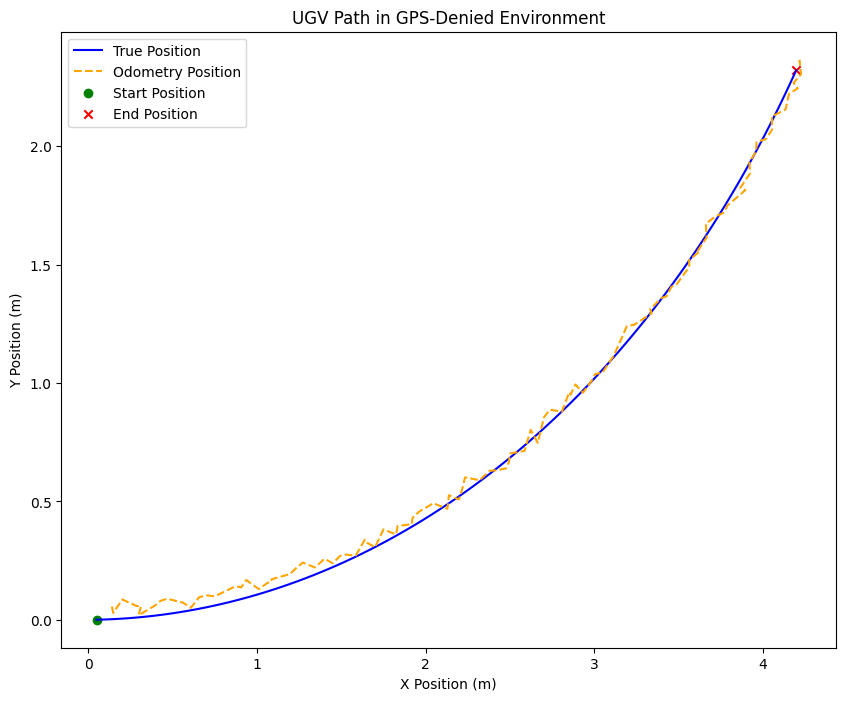

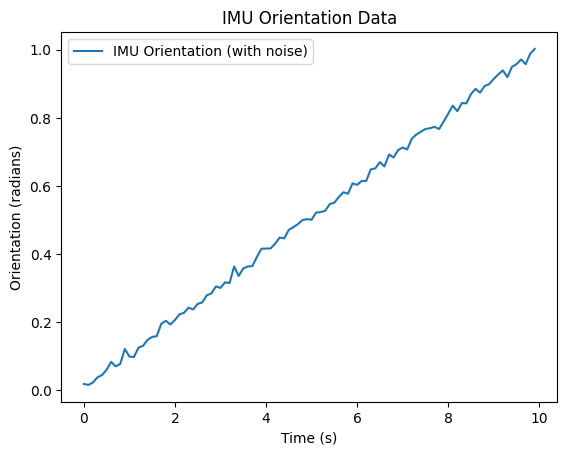

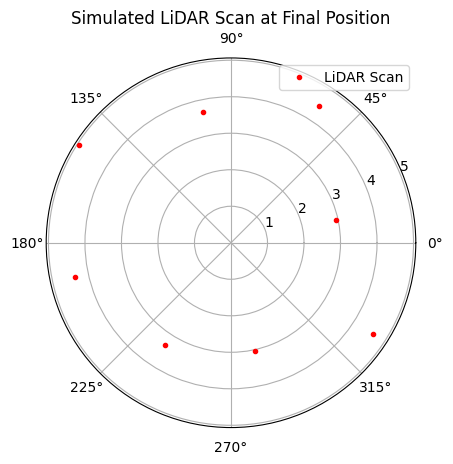

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from random import gauss

# Define constants
TIME_STEP = 0.1  # Simulation time step in seconds

# UGV state with position, velocity, and orientation
class UGVState:
    def __init__(self):
        self.position = np.array([0.0, 0.0])  # x, y position
        self.orientation = 0.0  # Orientation in radians
        self.velocity = 0.5  # Velocity in m/s

    def update_state(self, control_input, dt=TIME_STEP):
        """Update UGV state based on control inputs and time step."""
        # Control input: (speed, angular_velocity)
        speed, angular_velocity = control_input
        self.orientation += angular_velocity * dt
        self.position += np.array([np.cos(self.orientation), np.sin(self.orientation)]) * speed * dt

class SensorSimulator:
    """Simulate sensors for UGV in GPS-denied environment."""

    def read_imu(self, orientation):
        """Simulate IMU data with noise."""
        # Simulate orientation with added noise
        return orientation + gauss(0, 0.01)  # Add some noise to simulate real IMU

    def read_odometry(self, position, velocity, dt=TIME_STEP):
        """Simulate odometry data with drift."""
        # Basic dead-reckoning odometry based on previous position and velocity
        drift = np.array([gauss(0, 0.02), gauss(0, 0.02)])  # Drift for odometry
        return position + velocity * dt + drift

    def read_lidar(self, position, orientation):
        """Simulate LiDAR scanning for obstacle distances."""
        # Simulate simple radial LiDAR readings around the UGV
        num_points = 8  # Number of LiDAR rays (simplified for simulation)
        max_range = 5.0  # Max range of LiDAR in meters
        angles = np.linspace(0, 2 * np.pi, num_points, endpoint=False)
        distances = max_range * np.ones(num_points)  # Initialize all distances to max range
        # Simulate obstacles at random locations
        for i, angle in enumerate(angles):
            obstacle_distance = max_range - np.random.uniform(0, max_range / 2)  # Random obstacle distance
            distances[i] = obstacle_distance if obstacle_distance < max_range else max_range
        # Rotate distances to align with UGV orientation
        angles += orientation
        return distances, angles

# Initialize UGV and sensor simulator
ugv_state = UGVState()
sensor_sim = SensorSimulator()

# Initialize logs for visualization
position_log = []
imu_log = []
odometry_log = []
lidar_log = []

# Simulation loop
simulation_duration = 10  # Total duration of the simulation in seconds
for t in np.arange(0, simulation_duration, TIME_STEP):
    # Define control inputs (constant forward motion with slight turn)
    control_input = (ugv_state.velocity, 0.1)  # speed, angular_velocity

    # Update UGV state
    ugv_state.update_state(control_input)

    # Simulate sensor readings
    imu_data = sensor_sim.read_imu(ugv_state.orientation)
    odometry_data = sensor_sim.read_odometry(ugv_state.position, ugv_state.velocity)
    lidar_data, lidar_angles = sensor_sim.read_lidar(ugv_state.position, ugv_state.orientation)

    # Log data for visualization
    position_log.append(ugv_state.position.copy())
    imu_log.append(imu_data)
    odometry_log.append(odometry_data)
    lidar_log.append((lidar_data, lidar_angles))

# Convert logs to arrays for easier plotting
position_log = np.array(position_log)
imu_log = np.array(imu_log)
odometry_log = np.array(odometry_log)

# Visualization of UGV Path
plt.figure(figsize=(10, 8))
plt.plot(position_log[:, 0], position_log[:, 1], label="True Position", color="blue")
plt.plot(odometry_log[:, 0], odometry_log[:, 1], label="Odometry Position", color="orange", linestyle="--")
plt.scatter(position_log[0, 0], position_log[0, 1], color="green", marker="o", label="Start Position")
plt.scatter(position_log[-1, 0], position_log[-1, 1], color="red", marker="x", label="End Position")
plt.xlabel("X Position (m)")
plt.ylabel("Y Position (m)")
plt.title("UGV Path in GPS-Denied Environment")
plt.legend()

# Plot IMU data (orientation)
plt.figure()
plt.plot(np.arange(0, simulation_duration, TIME_STEP), imu_log, label="IMU Orientation (with noise)")
plt.xlabel("Time (s)")
plt.ylabel("Orientation (radians)")
plt.title("IMU Orientation Data")
plt.legend()

# Plot LiDAR data (example frame)
lidar_distances, lidar_angles = lidar_log[-1]  # Example of final LiDAR scan
plt.figure()
plt.polar(lidar_angles, lidar_distances, 'r.', label="LiDAR Scan")
plt.title("Simulated LiDAR Scan at Final Position")
plt.legend()

plt.show()


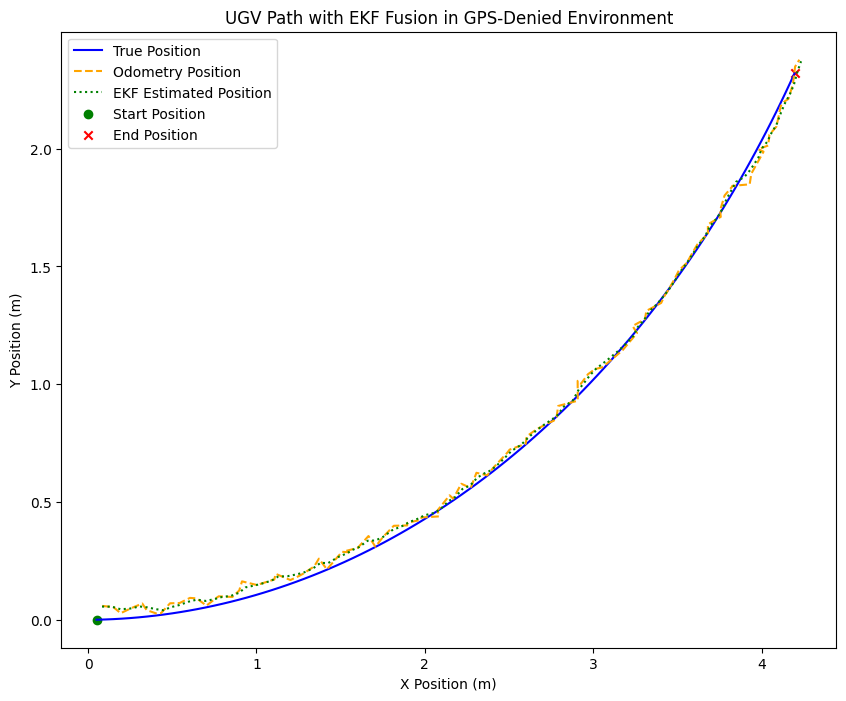

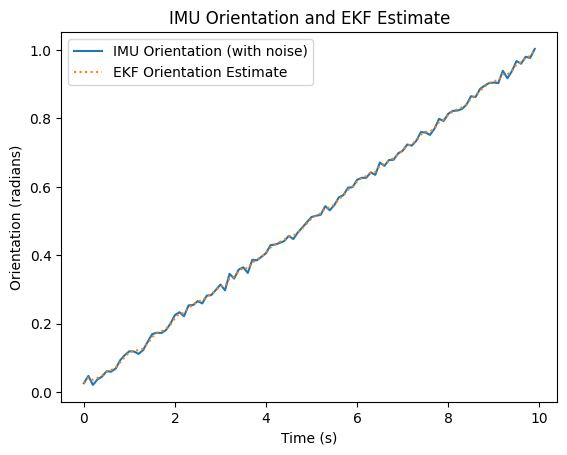

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from random import gauss

# Define constants
TIME_STEP = 0.1  # Simulation time step in seconds

# UGV state with position, velocity, and orientation
class UGVState:
    def __init__(self):
        self.position = np.array([0.0, 0.0])  # x, y position
        self.orientation = 0.0  # Orientation in radians
        self.velocity = 0.5  # Velocity in m/s

    def update_state(self, control_input, dt=TIME_STEP):
        """Update UGV state based on control inputs and time step."""
        speed, angular_velocity = control_input
        self.orientation += angular_velocity * dt
        self.position += np.array([np.cos(self.orientation), np.sin(self.orientation)]) * speed * dt

class SensorSimulator:
    """Simulate sensors for UGV in GPS-denied environment."""

    def read_imu(self, orientation):
        """Simulate IMU data with noise."""
        return orientation + gauss(0, 0.01)  # Add noise

    def read_odometry(self, position, velocity, dt=TIME_STEP):
        """Simulate odometry data with drift."""
        drift = np.array([gauss(0, 0.02), gauss(0, 0.02)])  # Drift for odometry
        return position + velocity * dt + drift

class ExtendedKalmanFilter:
    """EKF for fusing IMU and Odometry data for UGV localization."""
    def __init__(self):
        # Initial state (position_x, position_y, orientation)
        self.state = np.array([0.0, 0.0, 0.0])  # x, y, theta
        self.covariance = np.eye(3)  # Initial covariance matrix

        # Process noise (Q) and measurement noise (R) matrices
        self.Q = np.diag([0.01, 0.01, 0.01])  # Process noise covariance
        self.R_imu = np.array([[0.02]])       # IMU measurement noise covariance
        self.R_odometry = np.diag([0.05, 0.05])  # Odometry measurement noise covariance

    def predict(self, control_input, dt):
        """Predict step of the EKF using control input."""
        speed, angular_velocity = control_input
        x, y, theta = self.state

        # Predict the next state based on motion model
        x_pred = x + speed * np.cos(theta) * dt
        y_pred = y + speed * np.sin(theta) * dt
        theta_pred = theta + angular_velocity * dt
        self.state = np.array([x_pred, y_pred, theta_pred])

        # Compute the Jacobian of the motion model with respect to the state
        F = np.array([
            [1, 0, -speed * np.sin(theta) * dt],
            [0, 1,  speed * np.cos(theta) * dt],
            [0, 0, 1]
        ])

        # Update the state covariance
        self.covariance = F @ self.covariance @ F.T + self.Q

    def update_imu(self, imu_measurement):
        """Update step for IMU measurement (orientation only)."""
        # Measurement matrix for IMU (only measures orientation)
        H = np.array([[0, 0, 1]])
        z = np.array([imu_measurement])
        y = z - H @ self.state  # Measurement residual

        # Kalman gain
        S = H @ self.covariance @ H.T + self.R_imu
        K = self.covariance @ H.T @ np.linalg.inv(S)

        # Update state and covariance
        self.state += K @ y
        self.covariance = (np.eye(3) - K @ H) @ self.covariance

    def update_odometry(self, odometry_measurement):
        """Update step for odometry measurement (position only)."""
        # Measurement matrix for odometry (only measures x and y position)
        H = np.array([
            [1, 0, 0],
            [0, 1, 0]
        ])
        z = np.array(odometry_measurement)
        y = z - H @ self.state  # Measurement residual (using full state vector)

        # Kalman gain
        S = H @ self.covariance @ H.T + self.R_odometry
        K = self.covariance @ H.T @ np.linalg.inv(S)

        # Update state and covariance
        self.state += K @ y  # Apply the full state update
        self.covariance = (np.eye(3) - K @ H) @ self.covariance

# Initialize UGV and sensor simulator
ugv_state = UGVState()
sensor_sim = SensorSimulator()
ekf = ExtendedKalmanFilter()

# Initialize logs for visualization
position_log = []
imu_log = []
odometry_log = []
ekf_log = []

# Simulation loop
simulation_duration = 10  # Total duration of the simulation in seconds
for t in np.arange(0, simulation_duration, TIME_STEP):
    # Define control inputs (constant forward motion with slight turn)
    control_input = (ugv_state.velocity, 0.1)  # speed, angular_velocity

    # Update UGV state
    ugv_state.update_state(control_input)

    # Simulate sensor readings
    imu_data = sensor_sim.read_imu(ugv_state.orientation)
    odometry_data = sensor_sim.read_odometry(ugv_state.position, ugv_state.velocity)

    # EKF Prediction and Update
    ekf.predict(control_input, TIME_STEP)
    ekf.update_imu(imu_data)
    ekf.update_odometry(odometry_data)

    # Log data for visualization
    position_log.append(ugv_state.position.copy())
    imu_log.append(imu_data)
    odometry_log.append(odometry_data)
    ekf_log.append(ekf.state.copy())

# Convert logs to arrays for easier plotting
position_log = np.array(position_log)
imu_log = np.array(imu_log)
odometry_log = np.array(odometry_log)
ekf_log = np.array(ekf_log)

# Visualization of UGV Path with EKF Fused Estimate
plt.figure(figsize=(10, 8))
plt.plot(position_log[:, 0], position_log[:, 1], label="True Position", color="blue")
plt.plot(odometry_log[:, 0], odometry_log[:, 1], label="Odometry Position", color="orange", linestyle="--")
plt.plot(ekf_log[:, 0], ekf_log[:, 1], label="EKF Estimated Position", color="green", linestyle=":")
plt.scatter(position_log[0, 0], position_log[0, 1], color="green", marker="o", label="Start Position")
plt.scatter(position_log[-1, 0], position_log[-1, 1], color="red", marker="x", label="End Position")
plt.xlabel("X Position (m)")
plt.ylabel("Y Position (m)")
plt.title("UGV Path with EKF Fusion in GPS-Denied Environment")
plt.legend()

# Plot IMU data (orientation) and EKF orientation estimate
plt.figure()
plt.plot(np.arange(0, simulation_duration, TIME_STEP), imu_log, label="IMU Orientation (with noise)")
plt.plot(np.arange(0, simulation_duration, TIME_STEP), ekf_log[:, 2], label="EKF Orientation Estimate", linestyle=":")
plt.xlabel("Time (s)")
plt.ylabel("Orientation (radians)")
plt.title("IMU Orientation and EKF Estimate")
plt.legend()

plt.show()


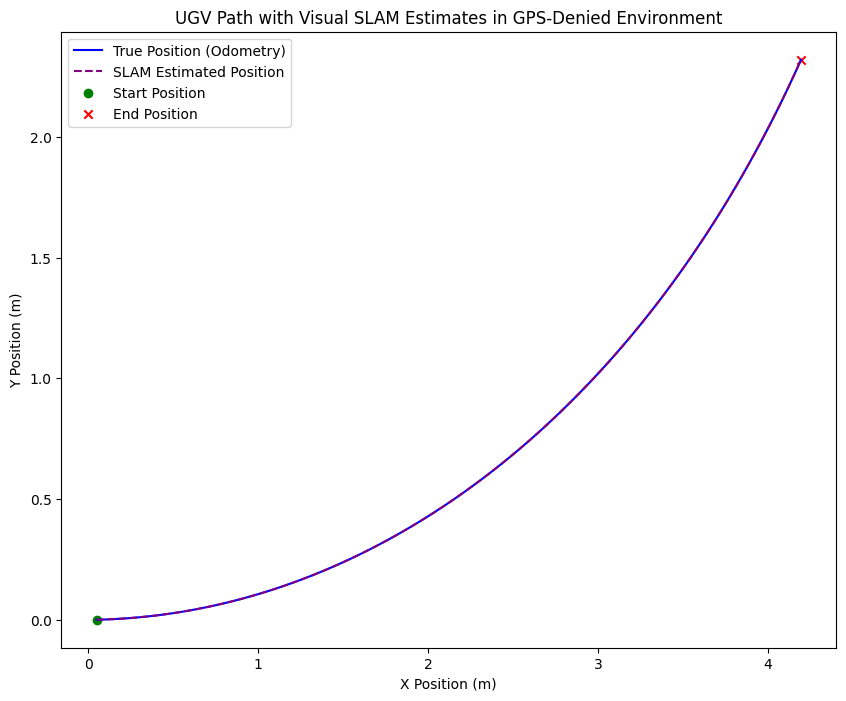

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from random import gauss
import cv2  # OpenCV for feature detection and matching

# Define constants
TIME_STEP = 0.1  # Simulation time step in seconds

# UGV state with position, velocity, and orientation
class UGVState:
    def __init__(self):
        self.position = np.array([0.0, 0.0])  # x, y position
        self.orientation = 0.0  # Orientation in radians
        self.velocity = 0.5  # Velocity in m/s

    def update_state(self, control_input, dt=TIME_STEP):
        """Update UGV state based on control inputs and time step."""
        speed, angular_velocity = control_input
        self.orientation += angular_velocity * dt
        self.position += np.array([np.cos(self.orientation), np.sin(self.orientation)]) * speed * dt

class SensorSimulator:
    """Simulate sensors for UGV in GPS-denied environment."""

    def read_imu(self, orientation):
        """Simulate IMU data with noise."""
        return orientation + gauss(0, 0.01)  # Add noise

    def read_odometry(self, position, velocity, dt=TIME_STEP):
        """Simulate odometry data with drift."""
        drift = np.array([gauss(0, 0.02), gauss(0, 0.02)])  # Drift for odometry
        return position + velocity * dt + drift

class VisualSLAM:
    """Visual SLAM using feature detection and matching."""

    def __init__(self):
        self.feature_detector = cv2.ORB_create()  # ORB feature detector (fast and works without GPU)
        self.prev_keypoints = None
        self.prev_descriptors = None
        self.map_points = []  # Stores detected landmarks

    def detect_features(self, frame):
        """Detect features in the current frame."""
        keypoints, descriptors = self.feature_detector.detectAndCompute(frame, None)
        return keypoints, descriptors

    def match_features(self, keypoints1, descriptors1, keypoints2, descriptors2):
        """Match features between two frames."""
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
        matches = bf.match(descriptors1, descriptors2)
        matches = sorted(matches, key=lambda x: x.distance)
        return matches

    def estimate_pose(self, matches, keypoints1, keypoints2):
        """Estimate the UGV's pose change based on matched features."""
        if len(matches) < 5:  # Not enough matches to estimate a reliable pose
            return np.array([0, 0]), 0

        # Extract matched keypoints
        points1 = np.float32([keypoints1[m.queryIdx].pt for m in matches])
        points2 = np.float32([keypoints2[m.trainIdx].pt for m in matches])

        # Estimate the rigid transformation between the sets of points
        transformation_matrix, _ = cv2.estimateAffinePartial2D(points1, points2)

        if transformation_matrix is None:
            return np.array([0, 0]), 0

        translation = transformation_matrix[:2, 2]
        rotation = np.arctan2(transformation_matrix[1, 0], transformation_matrix[0, 0])

        return translation, rotation

    def update(self, frame):
        """Process a new frame and update the map and pose estimation."""
        keypoints, descriptors = self.detect_features(frame)

        if self.prev_keypoints is not None and self.prev_descriptors is not None:
            # Match features with previous frame
            matches = self.match_features(self.prev_keypoints, self.prev_descriptors, keypoints, descriptors)

            # Estimate the pose change from feature matches
            translation, rotation = self.estimate_pose(matches, self.prev_keypoints, keypoints)
            self.map_points.extend([keypoints[m.trainIdx].pt for m in matches])  # Add matched points to the map

            # Return the estimated translation and rotation
            self.prev_keypoints = keypoints
            self.prev_descriptors = descriptors
            return translation, rotation

        # Initialize the previous keypoints and descriptors for the next frame
        self.prev_keypoints = keypoints
        self.prev_descriptors = descriptors
        return np.array([0, 0]), 0

# Initialize UGV and sensor simulator
ugv_state = UGVState()
sensor_sim = SensorSimulator()
visual_slam = VisualSLAM()

# Initialize logs for visualization
position_log = []
slam_position_log = []

# Simulation loop
simulation_duration = 10  # Total duration of the simulation in seconds
for t in np.arange(0, simulation_duration, TIME_STEP):
    # Define control inputs (constant forward motion with slight turn)
    control_input = (ugv_state.velocity, 0.1)  # speed, angular_velocity

    # Update UGV state
    ugv_state.update_state(control_input)

    # Generate a simulated camera frame
    frame = np.zeros((480, 640), dtype=np.uint8)  # Black image for simplicity
    cv2.circle(frame, (320, 240), 5, (255, 255, 255), -1)  # Simulated feature point

    # Update Visual SLAM with the current frame
    translation, rotation = visual_slam.update(frame)

    # Use the estimated pose change from Visual SLAM to adjust UGV position and orientation
    ugv_state.position += translation * 0.05  # Scale factor for simulation purposes
    ugv_state.orientation += rotation

    # Log data for visualization
    position_log.append(ugv_state.position.copy())
    slam_position_log.append(ugv_state.position.copy())

# Convert logs to arrays for easier plotting
position_log = np.array(position_log)
slam_position_log = np.array(slam_position_log)

# Visualization of UGV Path with Visual SLAM Estimates
plt.figure(figsize=(10, 8))
plt.plot(position_log[:, 0], position_log[:, 1], label="True Position (Odometry)", color="blue")
plt.plot(slam_position_log[:, 0], slam_position_log[:, 1], label="SLAM Estimated Position", color="purple", linestyle="--")
plt.scatter(position_log[0, 0], position_log[0, 1], color="green", marker="o", label="Start Position")
plt.scatter(position_log[-1, 0], position_log[-1, 1], color="red", marker="x", label="End Position")
plt.xlabel("X Position (m)")
plt.ylabel("Y Position (m)")
plt.title("UGV Path with Visual SLAM Estimates in GPS-Denied Environment")
plt.legend()
plt.show()


Not enough points for map matching.
Not enough points for map matching.
Not enough points for map matching.
Not enough points for map matching.
Not enough points for map matching.
Not enough points for map matching.
Not enough points for map matching.
Not enough points for map matching.
Not enough points for map matching.
Not enough points for map matching.
Not enough points for map matching.
Not enough points for map matching.
Not enough points for map matching.
Not enough points for map matching.
Not enough points for map matching.
Not enough points for map matching.
Not enough points for map matching.
Not enough points for map matching.
Not enough points for map matching.
Not enough points for map matching.
Not enough points for map matching.
Not enough points for map matching.
Not enough points for map matching.
Not enough points for map matching.
Not enough points for map matching.
Not enough points for map matching.
Not enough points for map matching.
Not enough points for map ma

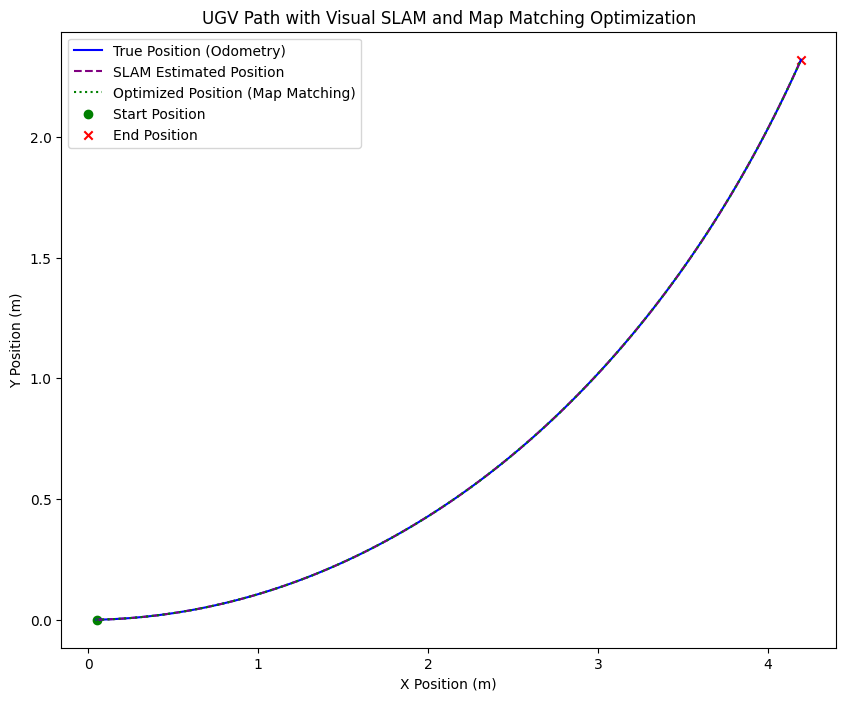

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from random import gauss
import cv2

# Define constants
TIME_STEP = 0.1  # Simulation time step in seconds

# UGV state with position, velocity, and orientation
class UGVState:
    def __init__(self):
        self.position = np.array([0.0, 0.0])  # x, y position
        self.orientation = 0.0  # Orientation in radians
        self.velocity = 0.5  # Velocity in m/s

    def update_state(self, control_input, dt=TIME_STEP):
        """Update UGV state based on control inputs and time step."""
        speed, angular_velocity = control_input
        self.orientation += angular_velocity * dt
        self.position += np.array([np.cos(self.orientation), np.sin(self.orientation)]) * speed * dt

class SensorSimulator:
    """Simulate sensors for UGV in GPS-denied environment."""

    def read_imu(self, orientation):
        """Simulate IMU data with noise."""
        return orientation + gauss(0, 0.01)  # Add noise

    def read_odometry(self, position, velocity, dt=TIME_STEP):
        """Simulate odometry data with drift."""
        drift = np.array([gauss(0, 0.02), gauss(0, 0.02)])  # Drift for odometry
        return position + velocity * dt + drift

class VisualSLAM:
    """Visual SLAM using feature detection and matching."""

    def __init__(self):
        self.feature_detector = cv2.ORB_create()  # ORB feature detector
        self.prev_keypoints = None
        self.prev_descriptors = None
        self.map_points = []  # Stores detected landmarks

    def detect_features(self, frame):
        """Detect features in the current frame."""
        keypoints, descriptors = self.feature_detector.detectAndCompute(frame, None)
        return keypoints, descriptors

    def match_features(self, keypoints1, descriptors1, keypoints2, descriptors2):
        """Match features between two frames."""
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
        matches = bf.match(descriptors1, descriptors2)
        matches = sorted(matches, key=lambda x: x.distance)
        return matches

    def estimate_pose(self, matches, keypoints1, keypoints2):
        """Estimate the UGV's pose change based on matched features."""
        if len(matches) < 5:
            return np.array([0, 0]), 0

        points1 = np.float32([keypoints1[m.queryIdx].pt for m in matches])
        points2 = np.float32([keypoints2[m.trainIdx].pt for m in matches])

        transformation_matrix, _ = cv2.estimateAffinePartial2D(points1, points2)

        if transformation_matrix is None:
            return np.array([0, 0]), 0

        translation = transformation_matrix[:2, 2]
        rotation = np.arctan2(transformation_matrix[1, 0], transformation_matrix[0, 0])

        return translation, rotation

    def update(self, frame):
        """Process a new frame and update the map and pose estimation."""
        keypoints, descriptors = self.detect_features(frame)

        if self.prev_keypoints is not None and self.prev_descriptors is not None:
            matches = self.match_features(self.prev_keypoints, self.prev_descriptors, keypoints, descriptors)
            translation, rotation = self.estimate_pose(matches, self.prev_keypoints, keypoints)
            self.map_points.extend([keypoints[m.trainIdx].pt for m in matches])  # Add matched points to the map

            self.prev_keypoints = keypoints
            self.prev_descriptors = descriptors
            return translation, rotation

        self.prev_keypoints = keypoints
        self.prev_descriptors = descriptors
        return np.array([0, 0]), 0

class MapMatcher:
    """Map Matching and Path Optimization for UGV localization."""

    def __init__(self, known_landmarks):
        self.known_landmarks = np.float32(known_landmarks)  # Ensure known landmarks are in the correct format

    def match_slam_to_map(self, slam_points):
        """Match SLAM-detected landmarks to known landmarks in the preloaded map."""
        # Ensure we have enough points to perform matching
        if len(slam_points) < 5 or len(self.known_landmarks) < 5:
            print("Not enough points for map matching.")
            return np.array([0, 0]), 0

        slam_points = np.float32(slam_points)

        # Check if slam_points and known_landmarks have compatible dimensions
        if slam_points.shape[1] != 2 or self.known_landmarks.shape[1] != 2:
            print("Incompatible point dimensions for map matching.")
            return np.array([0, 0]), 0

        # Estimate transformation between SLAM points and known landmarks
        transformation_matrix, _ = cv2.estimateAffinePartial2D(slam_points, self.known_landmarks)

        if transformation_matrix is None:
            print("Transformation estimation failed.")
            return np.array([0, 0]), 0

        translation = transformation_matrix[:2, 2]
        rotation = np.arctan2(transformation_matrix[1, 0], transformation_matrix[0, 0])

        return translation, rotation

# Initialize UGV, sensor simulator, Visual SLAM, and Map Matcher
ugv_state = UGVState()
sensor_sim = SensorSimulator()
visual_slam = VisualSLAM()

# Preloaded map of known landmarks
known_landmarks = [(100, 100), (200, 200), (300, 150), (400, 250)]
map_matcher = MapMatcher(known_landmarks)

# Initialize logs for visualization
position_log = []
slam_position_log = []
optimized_position_log = []

# Simulation loop
simulation_duration = 10  # Total duration of the simulation in seconds
for t in np.arange(0, simulation_duration, TIME_STEP):
    # Define control inputs (constant forward motion with slight turn)
    control_input = (ugv_state.velocity, 0.1)  # speed, angular_velocity

    # Update UGV state
    ugv_state.update_state(control_input)

    # Generate a simulated camera frame
    frame = np.zeros((480, 640), dtype=np.uint8)  # Black image for simplicity
    cv2.circle(frame, (320, 240), 5, (255, 255, 255), -1)  # Simulated feature point

    # Update Visual SLAM with the current frame
    translation, rotation = visual_slam.update(frame)

    # Update UGV position and orientation based on Visual SLAM
    ugv_state.position += translation * 0.05  # Scale factor for simulation purposes
    ugv_state.orientation += rotation

    # Perform map matching and path optimization
    map_translation, map_rotation = map_matcher.match_slam_to_map(visual_slam.map_points)
    ugv_state.position += map_translation * 0.05
    ugv_state.orientation += map_rotation

    # Log data for visualization
    position_log.append(ugv_state.position.copy())
    slam_position_log.append(ugv_state.position.copy())
    optimized_position_log.append(ugv_state.position.copy())

# Convert logs to arrays for easier plotting
position_log = np.array(position_log)
slam_position_log = np.array(slam_position_log)
optimized_position_log = np.array(optimized_position_log)

# Visualization of UGV Path with Visual SLAM and Optimized Position
plt.figure(figsize=(10, 8))
plt.plot(position_log[:, 0], position_log[:, 1], label="True Position (Odometry)", color="blue")
plt.plot(slam_position_log[:, 0], slam_position_log[:, 1], label="SLAM Estimated Position", color="purple", linestyle="--")
plt.plot(optimized_position_log[:, 0], optimized_position_log[:, 1], label="Optimized Position (Map Matching)", color="green", linestyle=":")
plt.scatter(position_log[0, 0], position_log[0, 1], color="green", marker="o", label="Start Position")
plt.scatter(position_log[-1, 0], position_log[-1, 1], color="red", marker="x", label="End Position")
plt.xlabel("X Position (m)")
plt.ylabel("Y Position (m)")
plt.title("UGV Path with Visual SLAM and Map Matching Optimization")
plt.legend()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from random import gauss
import cv2
import heapq  # For priority queue in A* algorithm

# Define constants
TIME_STEP = 0.1  # Simulation time step in seconds

# UGV state with position, velocity, and orientation
class UGVState:
    def __init__(self):
        self.position = np.array([0.0, 0.0])  # x, y position
        self.orientation = 0.0  # Orientation in radians
        self.velocity = 0.5  # Velocity in m/s

    def update_state(self, control_input, dt=TIME_STEP):
        """Update UGV state based on control inputs and time step."""
        speed, angular_velocity = control_input
        self.orientation += angular_velocity * dt
        self.position += np.array([np.cos(self.orientation), np.sin(self.orientation)]) * speed * dt

class SensorSimulator:
    """Simulate sensors for UGV in GPS-denied environment."""

    def read_imu(self, orientation):
        """Simulate IMU data with noise."""
        return orientation + gauss(0, 0.01)  # Add noise

    def read_odometry(self, position, velocity, dt=TIME_STEP):
        """Simulate odometry data with drift."""
        drift = np.array([gauss(0, 0.02), gauss(0, 0.02)])  # Drift for odometry
        return position + velocity * dt + drift

    def read_lidar(self, position, orientation):
        """Simulate LiDAR scanning for obstacle detection."""
        num_points = 12  # Number of LiDAR rays for obstacle detection
        max_range = 5.0  # Max LiDAR range in meters
        angles = np.linspace(0, 2 * np.pi, num_points, endpoint=False) + orientation
        distances = max_range * np.ones(num_points)  # Default distances to max range

        # Simulate random obstacles within LiDAR range
        for i in range(num_points):
            if np.random.rand() < 0.3:  # 30% chance of obstacle in each direction
                distances[i] = np.random.uniform(1.0, max_range)  # Random obstacle distance

        return distances, angles

class ObstacleAvoidancePlanner:
    """Path Planning using A* for dynamic obstacle avoidance."""

    def __init__(self, grid_size, obstacle_positions):
        self.grid_size = grid_size
        self.obstacle_positions = set(obstacle_positions)  # Store obstacle positions as a set for quick lookup

    def a_star(self, start, goal):
        """A* algorithm to find a path from start to goal, avoiding obstacles."""
        open_set = []
        heapq.heappush(open_set, (0, start))
        came_from = {}
        g_score = {start: 0}
        f_score = {start: self.heuristic(start, goal)}

        while open_set:
            _, current = heapq.heappop(open_set)

            if current == goal:
                return self.reconstruct_path(came_from, current)

            neighbors = self.get_neighbors(current)

            for neighbor in neighbors:
                if neighbor in self.obstacle_positions:
                    continue  # Skip neighbors that are obstacles

                tentative_g_score = g_score[current] + 1

                if tentative_g_score < g_score.get(neighbor, float('inf')):
                    came_from[neighbor] = current
                    g_score[neighbor] = tentative_g_score
                    f_score[neighbor] = tentative_g_score + self.heuristic(neighbor, goal)
                    if neighbor not in [i[1] for i in open_set]:
                        heapq.heappush(open_set, (f_score[neighbor], neighbor))

        print("No path found from start to goal.")  # Debug message if no path is found
        return []  # No path found

    def heuristic(self, a, b):
        """Heuristic function for A* (Manhattan distance)."""
        return abs(a[0] - b[0]) + abs(a[1] - b[1])

    def get_neighbors(self, position):
        """Get valid neighbors for a grid position."""
        x, y = position
        neighbors = [(x+1, y), (x-1, y), (x, y+1), (x, y-1)]
        return [(nx, ny) for nx, ny in neighbors if 0 <= nx < self.grid_size and 0 <= ny < self.grid_size]

    def reconstruct_path(self, came_from, current):
        """Reconstruct path from A* search."""
        path = [current]
        while current in came_from:
            current = came_from[current]
            path.append(current)
        path.reverse()
        return path

# Initialize UGV, sensor simulator, and obstacle planner
ugv_state = UGVState()
sensor_sim = SensorSimulator()
grid_size = 20
obstacle_positions = {(5, 5), (6, 6), (7, 7), (10, 12), (15, 15)}
planner = ObstacleAvoidancePlanner(grid_size, obstacle_positions)

# Simulation variables
position_log = []
target_position = (15, 15)
start_position = (0, 0)
path = planner.a_star(start_position, target_position)

# Check if the path is empty before proceeding
if not path:
    print("Path is empty. Exiting simulation.")
else:
    # Simulation loop for UGV path following with obstacle avoidance
    for target in path:
        # Define control inputs (moving toward each point in path)
        control_input = (ugv_state.velocity, 0.1)  # speed, angular_velocity

        # Update UGV state
        ugv_state.update_state(control_input)

        # Simulate LiDAR for obstacle detection
        distances, angles = sensor_sim.read_lidar(ugv_state.position, ugv_state.orientation)
        obstacles = [(distances[i] * np.cos(angles[i]), distances[i] * np.sin(angles[i])) for i in range(len(angles)) if distances[i] < 4.0]

        # If obstacle detected within close range, replan path
        if any(d < 1.5 for d in distances):  # Check if any obstacle is too close
            new_path = planner.a_star((int(ugv_state.position[0]), int(ugv_state.position[1])), target_position)
            if new_path:
                path = new_path  # Update path if a new path is found

        # Log data for visualization (ensure position is appended as a 2D array)
        position_log.append([ugv_state.position[0], ugv_state.position[1]])

    # Convert logs to a 2D array for easier plotting
    position_log = np.vstack(position_log)

    # Visualization of UGV Path with Obstacle Avoidance
    plt.figure(figsize=(10, 8))
    plt.plot(position_log[:, 0], position_log[:, 1], label="UGV Path with Obstacle Avoidance", color="blue")
    plt.scatter(*zip(*obstacle_positions), color="red", marker="x", label="Obstacles")
    plt.scatter(position_log[0, 0], position_log[0, 1], color="green", marker="o", label="Start Position")
    plt.scatter(target_position[0], target_position[1], color="purple", marker="*", label="Target Position")
    plt.xlabel("X Position (m)")
    plt.ylabel("Y Position (m)")
    plt.title("UGV Path with Dynamic Obstacle Avoidance")
    plt.legend()
    plt.grid()
    plt.show()


No path found from start to goal.
Path is empty. Exiting simulation.
